# Integration Example

We can use [pynucastro](https://github.com/pynucastro/pynucastro) to generate the righthand side function for an astrophysical reaction network.

We'll create a H=burning network that has the rates for all p+p and the basic CNO cycle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynucastro as pyna

In [2]:
rate_names = ["p(p,)d",
              "d(p,g)he3",
              "he3(he3,pp)he4",
              "c12(p,g)n13",
              "c13(p,g)n14",
              "n13(,)c13",
              "n14(p,g)o15",
              "n15(p,a)c12",
              "o15(,)n15"]

rl = pyna.ReacLibLibrary()
rates = rl.get_rate_by_name(rate_names)
rc = pyna.RateCollection(rates=rates)

We can visualize the network and rates linking the nuclei

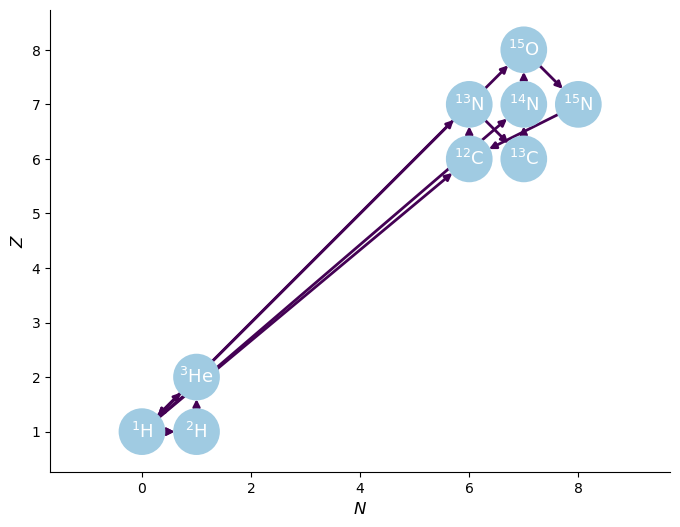

In [3]:
fig = rc.plot()

pynucastro can write out the python code needed to evaluate the reaction rates

In [4]:
pynet = pyna.PythonNetwork(rates=rates)
pynet.write_network("cno_integration_example.py")

In [5]:
%cat cno_integration_example.py

import numba
import numpy as np
from scipy import constants
from numba.experimental import jitclass

from pynucastro.rates import TableIndex, TableInterpolator, TabularRate, Tfactors
from pynucastro.screening import PlasmaState, ScreenFactors

jp = 0
jd = 1
jhe3 = 2
jhe4 = 3
jc12 = 4
jc13 = 5
jn13 = 6
jn14 = 7
jn15 = 8
jo15 = 9
nnuc = 10

A = np.zeros((nnuc), dtype=np.int32)

A[jp] = 1
A[jd] = 2
A[jhe3] = 3
A[jhe4] = 4
A[jc12] = 12
A[jc13] = 13
A[jn13] = 13
A[jn14] = 14
A[jn15] = 15
A[jo15] = 15

Z = np.zeros((nnuc), dtype=np.int32)

Z[jp] = 1
Z[jd] = 1
Z[jhe3] = 2
Z[jhe4] = 2
Z[jc12] = 6
Z[jc13] = 6
Z[jn13] = 7
Z[jn14] = 7
Z[jn15] = 7
Z[jo15] = 8

# masses in ergs
mass = np.zeros((nnuc), dtype=np.float64)

mass[jp] = 0.0015040963047307696
mass[jd] = 0.0030058819195053215
mass[jhe3] = 0.004501176706825056
mass[jhe4] = 0.0059735574859708365
mass[jc12] = 0.017909017027273523
mass[jc13] = 0.01940644192976114
mass[jn13] = 0.01940999951603316
mass[jn14] = 0.020898440897976135
mass[jn15] = 0

Now we can import the network that was just created

In [6]:
import cno_integration_example as cno

In [7]:
from scipy.integrate import solve_ivp

Now we'll set the thermodynamic conditions.  We'll pick the conditions inside the core of the Sun.  We initialize mass fractions and then convert to molar fractions, since that's what the RHS uses

In [8]:
rho = 150
T = 1.5e7

X = np.zeros(cno.nnuc)
X[cno.jp] = 0.7
X[cno.jhe4] = 0.28
X[cno.jc12] = 0.02

Y0 = X / cno.A
Y0

array([0.7       , 0.        , 0.        , 0.07      , 0.00166667,
       0.        , 0.        , 0.        , 0.        , 0.        ])

We'll use the BDF solver from SciPy--this works well with "stiff" reaction networks.

In [9]:
tmax = 1.e20

sol = solve_ivp(cno.rhs, [0, tmax], Y0, method="BDF", jac=cno.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-8, atol=1.e-10)

In [10]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04 ...  8.201e+19  1.000e+20]
        y: [[ 7.000e-01  7.000e-01 ... -3.175e-20 -6.269e-21]
            [ 0.000e+00  2.992e-22 ... -1.319e-11 -1.658e-11]
            ...
            [ 0.000e+00  1.888e-71 ...  3.859e-08  3.859e-08]
            [ 0.000e+00  3.937e-65 ... -9.641e-37 -1.904e-37]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f162d7a6ff0>
 t_events: None
 y_events: None
     nfev: 1286
     njev: 31
      nlu: 176

Now we can plot the mass fractions.

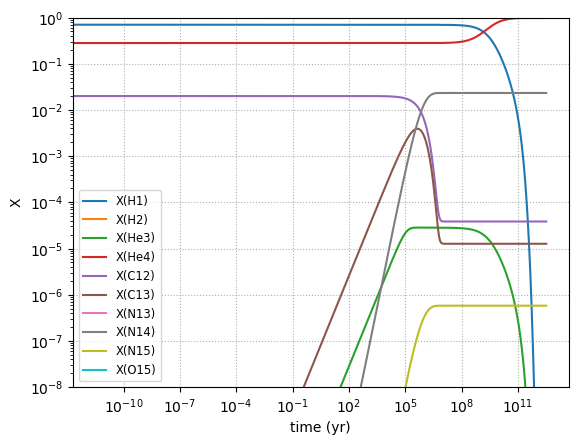

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

seconds_per_year = 60 * 60 * 24 * 365.25
for n in range(cno.nnuc):
    ax.loglog(sol.t / seconds_per_year, sol.y[n,:] * cno.A[n], label=f"X({cno.names[n].capitalize()})")

#ax.set_xlim(1.e8, 1.e13)
ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("time (yr)")
ax.set_ylabel("X")
ax.grid(ls=":")